In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv


# Introduction

In the paper "Modeling wine preferences by data mining from physicochemical properties" - Cortez et al. 2009, the authors note that "each sample was evaluated by a ***minimum of three*** sensory assessors (using blind tastes) who graded the wine in a scale that ranges from 0 (very bad) to 10 (excellent). The final sensory score is given by the median of these evaluations."

It is clear from the statement that multiple human judges who were not the same for every sample, and indeed in different numbers with a minimum of three per wine, were involved in tasting and rating the wines.

# Bayesian Error - Human sensors

Sensory perception of taste is a purely neurophysiological phenomenon in our consciousness generated in the brain which is highly susceptible to noise and bias owing to the prior state of the brain, i.e. evolutionary genetics, personal genetics and personal life experiences (eg. wine tasting, mood etc) and only partly relies on the sensory input. This fact of life makes humans poor sensors which will most certainly reflect in the Bayesian error for this dataset. Some ways to minimise this Bayesian error would be:

1. Have the same judges in the same number for every wine
2. Increase the number of judges per wine
3. Limit the number of wines rated per day
4. Ensure similar class distribution of wines rated per day (for eg. 1x bad, 2x average, 1x good)
5. Ensure each of the judges are in a similar state of mind on different days

Given these uncertainties, a **Bayesian error of +/-0.5** seems perfectly plausible on a continous scale of 0 - 10. Nonetheless, the purpose of the model is to provide decision support to an oenologist's wine tasting evaluations and improve wine production. Hence, the rating method is adequate.

# Weber-Fechner Law in psychophysics

Psychophysics is the study of quantitative relations between psychological events and physical events or, more specifically, between sensations and the stimuli that produce them. According to the Weber-Fechner Law, the relationship between stimulus and perception is logarithmic. This is indeed well known for the perception of the intensities of sounds and lights etc. This is attributed to the response of neurons that is in proportion to the logarithm of stimulus intensity.

See ref: https://en.wikipedia.org/wiki/Weber%E2%80%93Fechner_law

# Regression or Classification?

As noted by the authors of the paper, the wines were rated on a continuous scale from 0 to 10. The model is intended to provide decision support to the oenologist. Hence, a regression model is more useful than a classification model. For instance, if an oenologist rates a wine as a 4.0, the model prediction is more helpful as a floating point number like 4.7 than a rounded class number like 5.0. Hence, this may very well be treated as a regression problem. For the sake of comparison I shall also carry out a multi-class classification.

In [2]:
df_main = pd.read_csv("/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv")

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Exploratory data analyis

In [4]:
df = df_main.copy()
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
#Dropping duplicates

df.drop_duplicates(inplace = True)
df.reset_index(drop = True, inplace = True)
df.shape

(1359, 12)

In [6]:
#Ensuring all data are in appropriate format

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359 entries, 0 to 1358
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1359 non-null   float64
 1   volatile acidity      1359 non-null   float64
 2   citric acid           1359 non-null   float64
 3   residual sugar        1359 non-null   float64
 4   chlorides             1359 non-null   float64
 5   free sulfur dioxide   1359 non-null   float64
 6   total sulfur dioxide  1359 non-null   float64
 7   density               1359 non-null   float64
 8   pH                    1359 non-null   float64
 9   sulphates             1359 non-null   float64
 10  alcohol               1359 non-null   float64
 11  quality               1359 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 127.5 KB


In [7]:
#Checking for missing values
missing_data = df.isnull()
missing_data.sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [8]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,5.623252
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,0.823578
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Let's have a look at the features and labels.

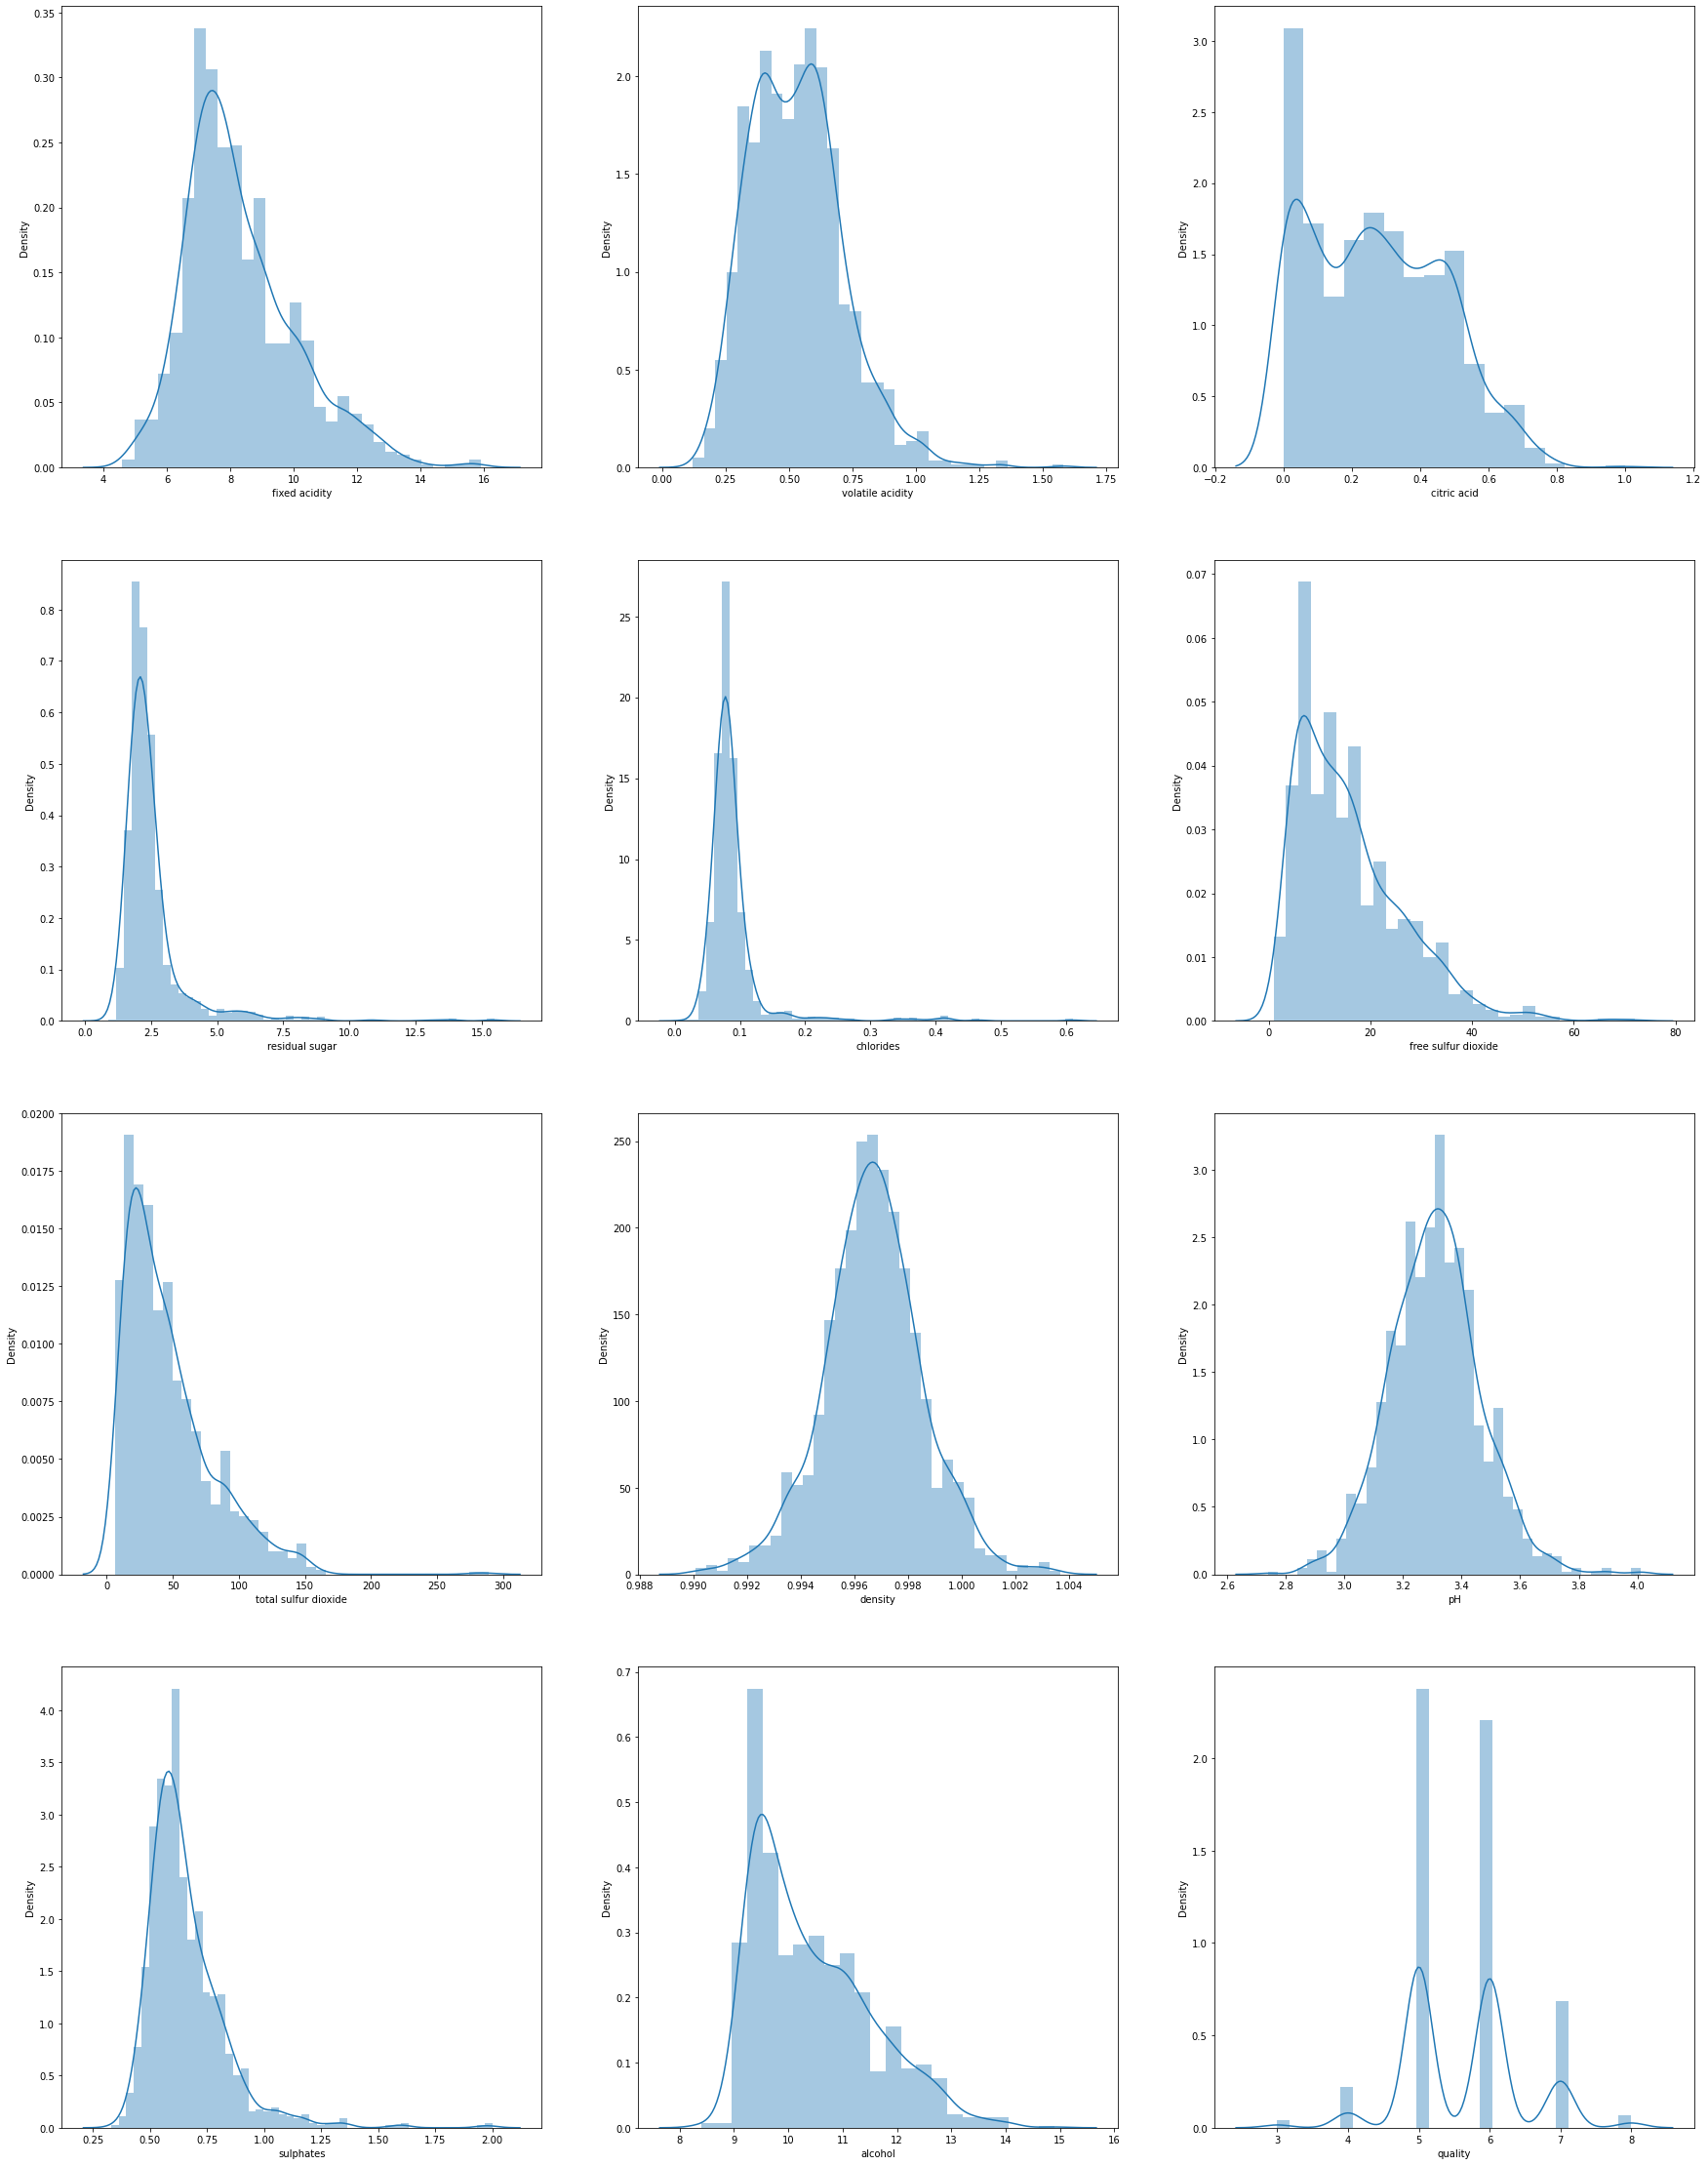

In [9]:
fig, ax = plt.subplots(ncols = 3, nrows = 4, figsize = (30, 40), squeeze=False)
index = 0
ax = ax.flatten()

for col in list(df.columns):
    sns.distplot(df[col], ax=ax[index], hist=True)
    index += 1

plt.draw()

In [10]:
#Counting the number of samples per quality class

df['quality'].value_counts().sort_index()

3     10
4     53
5    577
6    535
7    167
8     17
Name: quality, dtype: int64

Ideally, we'd like to see fairly equal number of wines in every class or rating. We see that the dataset is highly skewed with good number of samples for ratings 5 & 6, and hopelessly few samples for ratings 3, 4 & 8. This is expected if the sampling is done randomnly as the wines will indeed be normally distributed around the mean. Sadly, this means we cannot expect good accuracies and will just have to make the best out of this dataset.

Let's see how the features and labels are correlated with a pairplot.

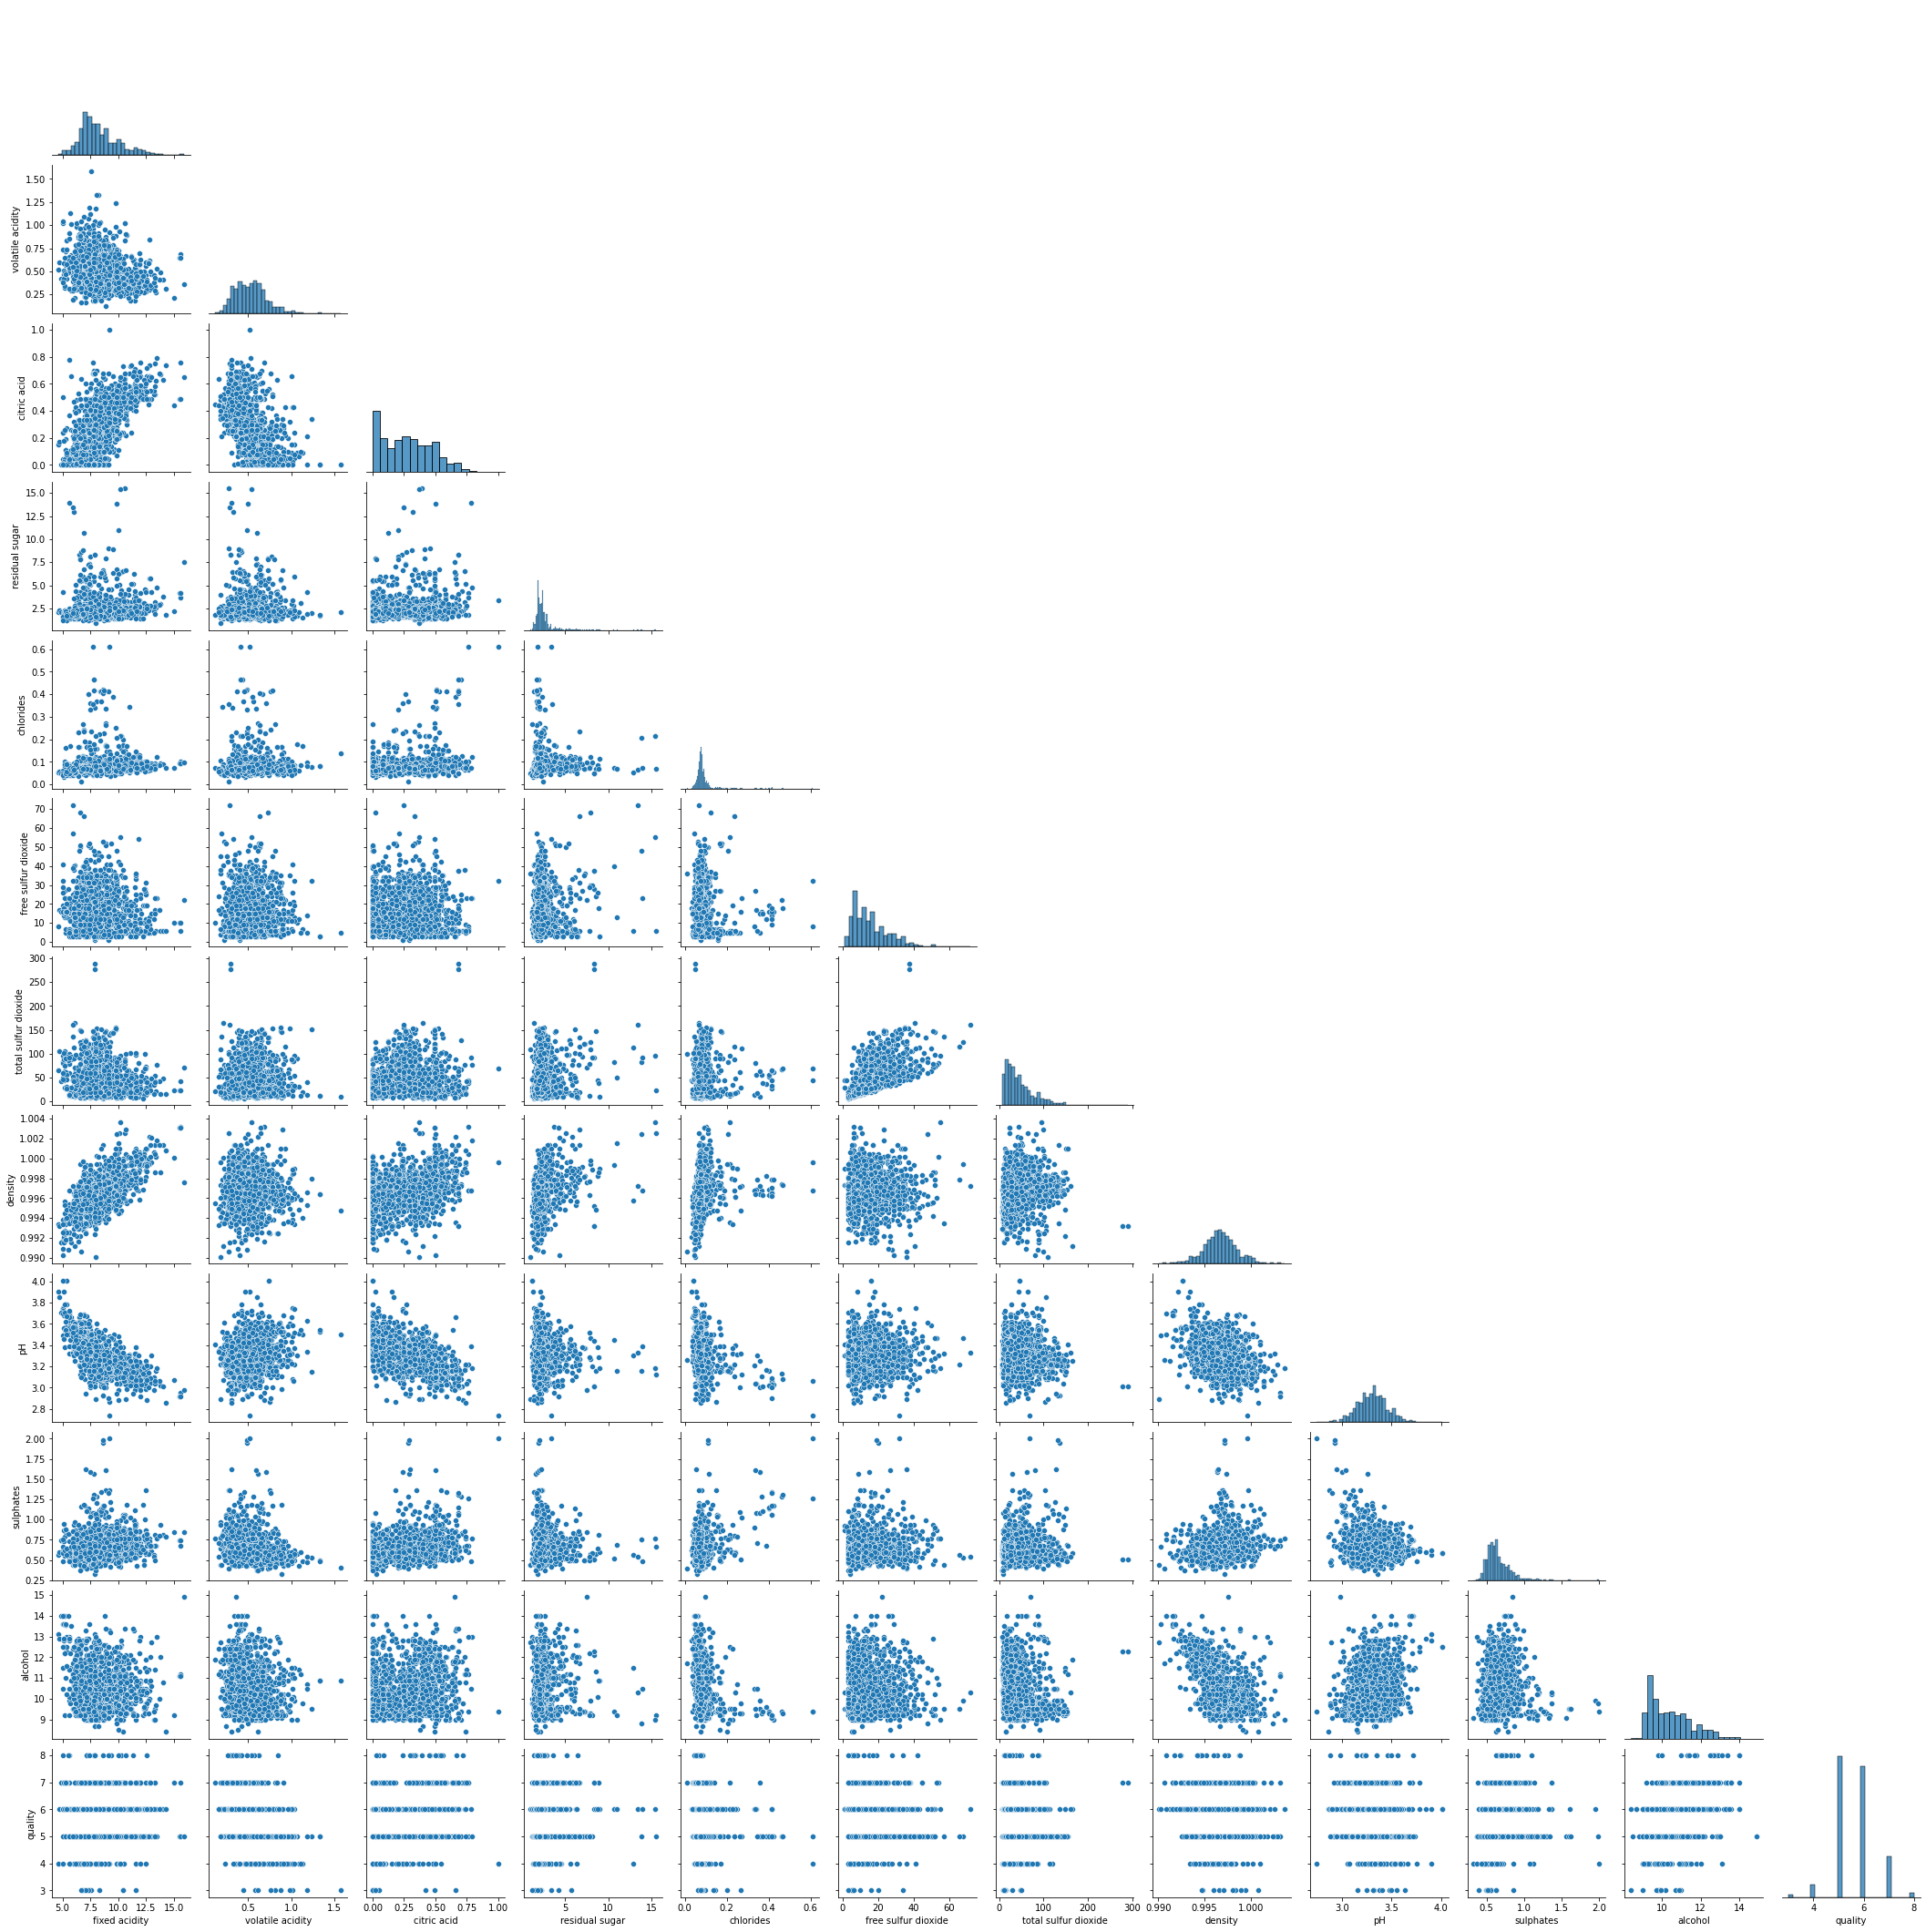

In [11]:
sns.pairplot(df, diag_kind='hist', corner=True)
plt.show()

We see that most features have a very weak relationship with the quality of the wine.

## Logarithmic transformation

As noted in an earlier section, a logarithmic transformation of the features is in line with the Weber-Fechner Law in psychophysics. Care is taken to NOT apply this to the feature **pH**. This is due to the fact that pH is already calculated as logarithm of the concentration of H+ radicals. The base-10 logarithm of pH is not a concern as I will be normalising the dataset prior to modelling.

As seen under df.describe() in the feature column 'citric acid' there are values = 0. In order to avoid -inf values with the logarithmic transformation the zeros are replaced with a negligible value of 0.001 mg/dm^3

In [12]:
df_log = df.copy()
df_log.loc[df_log['citric acid'] == 0, 'citric acid'] += 0.001

df_log.loc[:, ~df.columns.isin(['pH', 'quality'])] = np.log(df_log)
df_log.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,2.001480,-0.356675,-6.907755,0.641854,-2.577022,2.397895,3.526361,-0.002202,3.51,-0.579818,2.240710,5
1,2.054124,-0.127833,-6.907755,0.955511,-2.322788,3.218876,4.204693,-0.003205,3.20,-0.385662,2.282382,5
2,2.054124,-0.274437,-3.218876,0.832909,-2.385967,2.708050,3.988984,-0.003005,3.26,-0.430783,2.282382,5
3,2.415914,-1.272966,-0.579818,0.641854,-2.590267,2.833213,4.094345,-0.002002,3.16,-0.544727,2.282382,6
4,2.001480,-0.415515,-6.907755,0.587787,-2.590267,2.564949,3.688879,-0.002202,3.51,-0.579818,2.240710,5


Next we represent correlations between all variables as a heatmap.

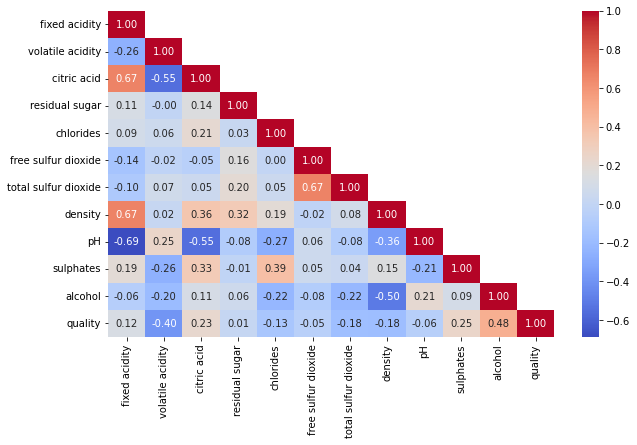

In [13]:
#Correlation heatmap

hmap_mask = np.triu(df_log.corr(), k=1)
plt.rc('font', size=10)
plt.figure(figsize=(10,6))

sns.heatmap(df.corr(), mask=hmap_mask, annot = True, fmt='.2f', cmap='coolwarm', annot_kws={"fontsize":10})
plt.show()

The correlation coefficients help us to:
1. estimate the effect size of every feature (Thresholds for +/- relationships 0.0: No relationship, 0.3: Weak relationship, 0.5: Moderate relationship, >0.7: Strong relationship, 1.0: Perfect relationship.) &
2. to decide if we need to drop any one of two features which are strongly correlated.

Based on the correlation coefficients we can estimate following order of size effect on quality:
alcohol(+) < volatile acidity (-) < sulphates (+) < citric acid (+) < density (-) = total sulphur dioxide (-) < chlorides (-) < fixed acidity (+) < pH (-) < free sulphur dioxide (-) < residual sugar

Since no independent variables have a correlation > 0.7 we don't drop any of them. Let's start modelling!

# Regression

## Evaluation Metric
The metric used to evaluate and compare the models will be mean absolute error (MAE). For the purpose of providing decision support to an oenologist a model with an error of **+/- 0.5** can be very useful. Although this may account for a 5% error margin on a continuous scale of 0 - 10, given the Bayesian error estimate and the inadequacy of the dataset in number of samples for quality ratings lesser or greater than 5 & 6, it is perfectly acceptable.

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [15]:
#Splitting data into features (X) and labels (y):

X = df_log.drop('quality', axis = 1)
y = df_log.iloc[:,-1:]

In [16]:
#Normalising the values with standard scaler:

St_sc = StandardScaler()
X_norm=X.copy()
X_norm[X_norm.columns]=pd.DataFrame(St_sc.fit_transform(X_norm))
X_norm.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.478150,0.956002,-2.770027,-0.589987,-0.220794,-0.219376,-0.109890,0.584642,1.291872,-0.603155,-0.988165
1,-0.214845,1.599423,-2.770027,0.306497,0.536033,0.981507,0.843794,0.049674,-0.708395,0.263163,-0.572478
2,-0.214845,1.187226,-0.689806,-0.043920,0.347956,0.234301,0.540524,0.156711,-0.321247,0.061837,-0.572478
3,1.594699,-1.620281,0.798402,-0.589987,-0.260223,0.417382,0.688653,0.691572,-0.966495,-0.446579,-0.572478
4,-0.478150,0.790564,-2.770027,-0.744519,-0.260223,0.024981,0.118600,0.584642,1.291872,-0.603155,-0.988165


In [17]:
#Defining the stratified k-Fold cross validation with 10 splits

cv = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

In [18]:
#Defining dataframe to save result

df_reg_result = pd.DataFrame(index=['Linear Regression', 'XGBoost Regression', 'Random Forest Regression', 'Support Vector Regression'], columns=['Mean absolute error', 'R^2 score'])

## Linear Regression

First, let's start with a simple multiple linear regression model.

In [19]:
from sklearn.linear_model import LinearRegression

LModel = LinearRegression()

In [20]:
y_LM = cross_val_predict(LModel, X_norm, y, cv=cv, n_jobs=2)
MAE_LM = round(mean_absolute_error(y , y_LM),3)
r2_LM = round(r2_score(y, y_LM),3)
df_reg_result['Mean absolute error']['Linear Regression']=MAE_LM
df_reg_result['R^2 score']['Linear Regression']=r2_LM
print(('MAE, Linear Regression').ljust(30), ': %.3f' % MAE_LM)
print(('R2 score, Linear Regression').ljust(30), ': %.3f' % r2_LM)

MAE, Linear Regression         : 0.513
R2 score, Linear Regression    : 0.342


## XGBoost Regressor

Let's see how we fare with the XGBoost Regressor.

In [21]:
from xgboost import XGBRegressor

I arrived at the best hyperparameters used below after carrying out a grid search for learning rate, maximum depth and number of estimators to minimise mean absolute error.

In [22]:
XGBModel_best = XGBRegressor(learning_rate = 0.01, max_depth=3, n_estimators=425)

In [23]:
y_XGB = cross_val_predict(XGBModel_best, X_norm, y, cv=cv, n_jobs=2)
MAE_XGB = round(mean_absolute_error(y , y_XGB),3)
r2_XGB = round(r2_score(y, y_XGB),3)
df_reg_result['Mean absolute error']['XGBoost Regression']=MAE_XGB
df_reg_result['R^2 score']['XGBoost Regression']=r2_XGB
print(('MAE, XGBoost Regression').ljust(30), ': %.3f' % MAE_XGB)
print(('R2 score, XGBoost Regression').ljust(30), ': %.3f' % r2_XGB)

MAE, XGBoost Regression        : 0.505
R2 score, XGBoost Regression   : 0.366


There is improvement over the linear regression model. Let's try a random forest regressor next.

## Random Forest Regressor

In [24]:
from sklearn.ensemble import RandomForestRegressor

Again, I arrived at the following hyperparameters after carrying out a grid search to minimise the loss function, mean absolute error.

In [25]:
np.random.seed(0)
RFModel_best = RandomForestRegressor(max_depth=7, n_estimators=100)
y_RF = cross_val_predict(RFModel_best, X_norm, y, cv=cv, n_jobs=2)
MAE_RF = round(mean_absolute_error(y , y_RF),3)
r2_RF = round(r2_score(y, y_RF),3)
df_reg_result['Mean absolute error']['Random Forest Regression']=MAE_RF
df_reg_result['R^2 score']['Random Forest Regression']=r2_RF
print(('MAE, Random Forest Regression').ljust(30), ': %.3f' % MAE_RF)
print(('R2 score, Random Forest Regression').ljust(30), ': %.3f' % r2_RF)

MAE, Random Forest Regression  : 0.510
R2 score, Random Forest Regression : 0.370


Sadly, not much of an improvement really.

## Support Vector Regressor

Let's try one more - support vector regressor.

In [26]:
from sklearn.svm import SVR

Defining support vector regressor with hyperparameters picked by means of a grid search.

In [27]:
SVRModel_best = SVR(kernel='rbf', C=0.5, gamma= 0.05, epsilon=9e-10)

In [28]:
y_SVR = cross_val_predict(SVRModel_best, X_norm, y, cv=cv, n_jobs=2)
MAE_SVR = round(mean_absolute_error(y , y_SVR),3)
r2_SVR = round(r2_score(y, y_SVR),3)
df_reg_result['Mean absolute error']['Support Vector Regression']=MAE_SVR
df_reg_result['R^2 score']['Support Vector Regression']=r2_SVR
print(('MAE, Support Vector Regression').ljust(30), ': %.3f' % MAE_SVR)
print(('R2 score, Support Vector Regression').ljust(30), ': %.3f' % r2_SVR)

MAE, Support Vector Regression : 0.487
R2 score, Support Vector Regression : 0.364


## Summary Regression

In [29]:
arr_y_reg=np.column_stack([y_LM, y_XGB, y_RF, y_SVR])

df_y_reg = pd.DataFrame(arr_y_reg, columns=['Linear Regression', 'XGBoost Regression', 'Random Forest Regression', 'Support Vector Regression'])

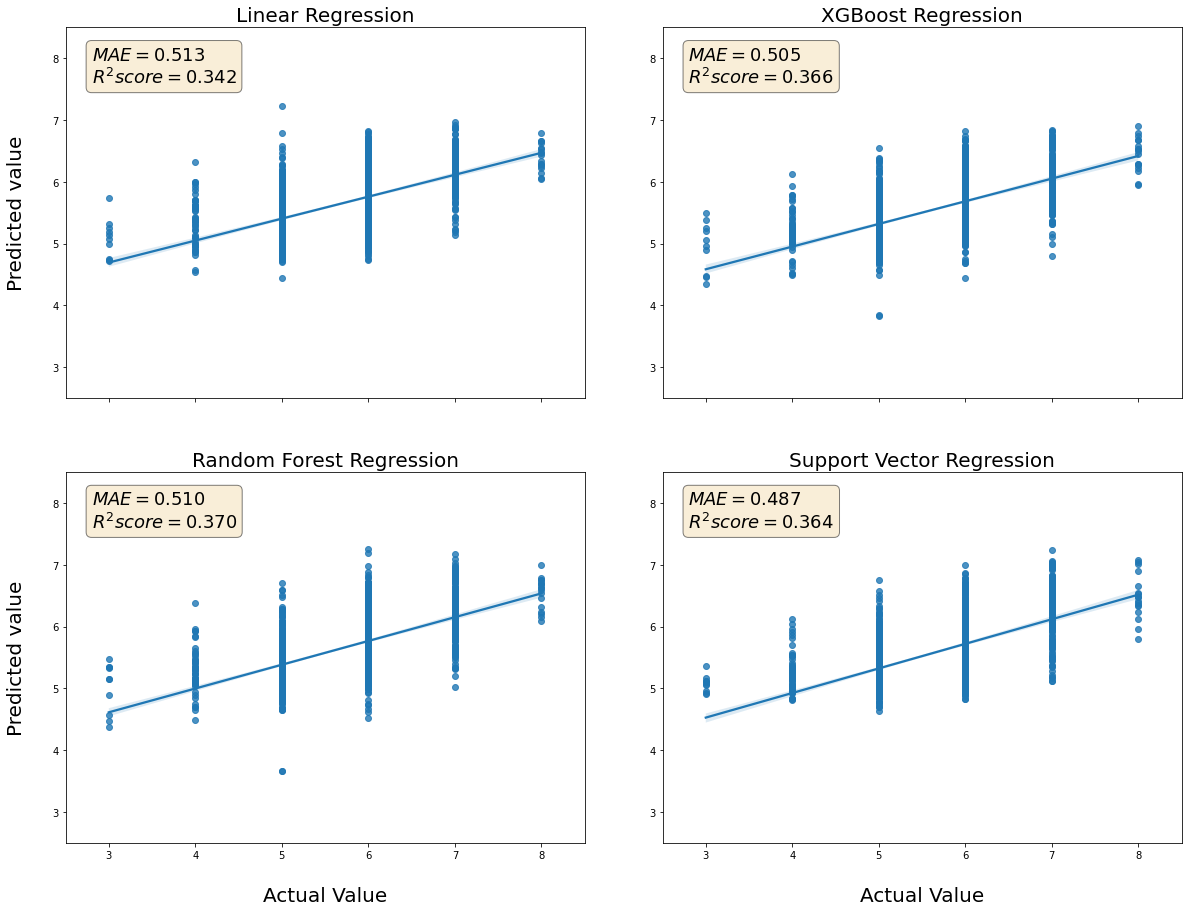

In [30]:
fig, ax = plt.subplots(ncols = 2, nrows = 2, squeeze=False, figsize = (20, 15))
index = 0
ax = ax.flatten()
plt.subplots_adjust(wspace=0.15, 
                    hspace=0.2)

params = {'axes.titlesize': 30, 'xtick.labelsize':18, 'ytick.labelsize':18}
plt.rcParams.update(params)

text_box = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

for col in df_y_reg:
    sns.regplot(y['quality'], df_y_reg[col], ax=ax[index])
    ax[index].set_title(col, fontsize=20)
    
    if (index % 2) == 0:
        ax[index].set_ylabel('Predicted value\n', fontsize=20)
    else:
        ax[index].set(ylabel=None)
    
    if index < 2:
        ax[index].set(xlabel=None)
        ax[index].tick_params(labelbottom=False)
    else:
        ax[index].set_xlabel('\nActual Value', fontsize=20)

    textstr = '\n'.join(('$MAE = %.3f$' % (df_reg_result['Mean absolute error'][col], ),
    '$R^2 score = %.3f$' % (df_reg_result['R^2 score'][col], )))
    
    ax[index].text(0.05, 0.95, textstr, transform=ax[index].transAxes, fontsize=18, verticalalignment='top', bbox=text_box)
    index += 1

plt.setp(ax, xlim=(2.5,8.5), ylim=(2.5,8.5))
plt.draw()

We see that the mean absolute error with all the models are pretty close to our Bayesian error estimate of +/- 0.5. Clearly, the Support Vector Regressor gives the best results.

# Classification

## Support Vector Regressor -> Classifier

Let us view the above regression results in a confusion matrix by rounding the predictions into whole number class bins. To do this we round the predictions to the nearest integer value. This in effect gives us the precision of the model within a tolerance of +/- 0.5. Moreover, in order to evaluate the precision of the model within a tolerance of +/- 1.0 we round the predicted values to the actual values when the absolute value of the error < 1.

In [31]:
y_SVR_mat = pd.DataFrame(columns=['Actual', 'Predicted', 'Round_0.5', 'Round_1.0'])
y_SVR_mat['Actual'] = y.copy()
y_SVR_mat['Predicted'] = np.round(y_SVR,3)
y_SVR_mat['Round_0.5']= np.round(y_SVR)
y_SVR_mat['Round_1.0'] = np.where(abs(y_SVR_mat['Actual']-y_SVR_mat['Predicted'])<1, y_SVR_mat['Actual'], y_SVR_mat['Round_0.5'])
y_SVR_mat.head()

,Actual,Predicted,Round_0.5,Round_1.0
0,5,4.984,5.0,5.0
1,5,5.140,5.0,5.0
2,5,5.193,5.0,5.0
3,6,5.360,5.0,6.0
4,5,5.008,5.0,5.0


Let's view the confusion matrix for a tolerance of +/- 0.5.

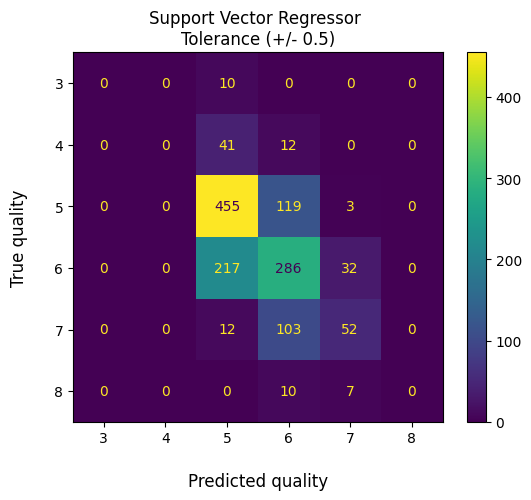

In [32]:
cm_SVR_05 = confusion_matrix(y_SVR_mat['Actual'], y_SVR_mat['Round_0.5'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_SVR_05, display_labels=np.unique(y_SVR_mat['Actual']))
plt.rcParams.update(plt.rcParamsDefault)
disp.plot()
plt.title('Support Vector Regressor \nTolerance (+/- 0.5)')
plt.xlabel('\nPredicted quality', fontsize=12)
plt.ylabel('True quality\n', fontsize=12)
plt.show()

In [33]:
print(classification_report(y_SVR_mat['Actual'], y_SVR_mat['Round_0.5'], digits=3))

              precision    recall  f1-score   support

           3      0.000     0.000     0.000        10
           4      0.000     0.000     0.000        53
           5      0.619     0.789     0.694       577
           6      0.540     0.535     0.537       535
           7      0.553     0.311     0.398       167
           8      0.000     0.000     0.000        17

    accuracy                          0.584      1359
   macro avg      0.285     0.272     0.272      1359
weighted avg      0.543     0.584     0.555      1359



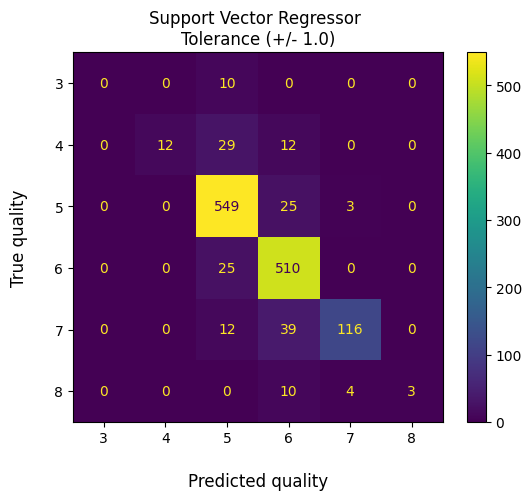

In [34]:
cm_SVR_10 = confusion_matrix(y_SVR_mat['Actual'], y_SVR_mat['Round_1.0'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_SVR_10, display_labels=np.unique(y_SVR_mat['Actual']))
plt.rcParams.update(plt.rcParamsDefault)
disp.plot()
plt.title('Support Vector Regressor \nTolerance (+/- 1.0)')
plt.xlabel('\nPredicted quality', fontsize=12)
plt.ylabel('True quality\n', fontsize=12)
plt.show()

In [35]:
print(classification_report(y_SVR_mat['Actual'], y_SVR_mat['Round_1.0'], digits=3))

              precision    recall  f1-score   support

           3      0.000     0.000     0.000        10
           4      1.000     0.226     0.369        53
           5      0.878     0.951     0.913       577
           6      0.856     0.953     0.902       535
           7      0.943     0.695     0.800       167
           8      1.000     0.176     0.300        17

    accuracy                          0.876      1359
   macro avg      0.780     0.500     0.547      1359
weighted avg      0.877     0.876     0.859      1359



As you can see, with a tolerance level of +/- 1.0 we arrive at the following precision values for predicted values in the continuous scale of 0 - 10:

**Rating-1:** 0%;
**Rating-2:** 0%;
**Rating-3:** 0%;
**Rating-4:** 100%;
**Rating-5:** 87.8%;
**Rating-6:** 85.6%;
**Rating-7:** 94.3%;
**Rating-8:** 100%;
**Rating-9:** 0%;
**Rating-10:** 0%;

## Random Forest Classifier
Now let us build a classification model for comparison. I choose the Random Forest Classifier as it allows one to easily tune the weights in each class and as well as view the feature importances easily.

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [37]:
#Setting the weights of every class to compensate for the imbalance in the dataset

weights_RFC = {3:5.0, 4:7.0, 5:1.0, 6:1.25, 7:3.0, 8:5.0}

In [38]:
np.random.seed(0)

model_RFC_best = RandomForestClassifier(max_depth=10, n_estimators=500, class_weight=weights_RFC)
y_RFC_6 = cross_val_predict(model_RFC_best, X_norm, y, cv=cv, n_jobs=2)

RFC_6_acc = accuracy_score(y['quality'], y_RFC_6)
print("Accuracy for binary classification with RFC is: " + str(round(RFC_6_acc*100,2)) + " %")

Accuracy for binary classification with RFC is: 57.84 %


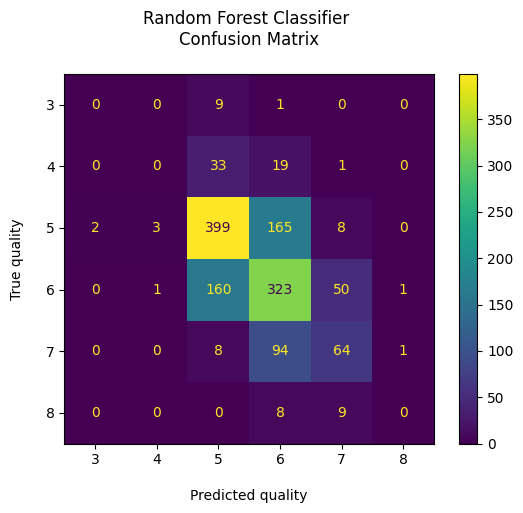

In [39]:
cm_RF = confusion_matrix(y['quality'], y_RFC_6)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_RF, display_labels=np.unique(y['quality']))
disp.plot()
plt.title('Random Forest Classifier \nConfusion Matrix\n')
plt.xlabel('\nPredicted quality')
plt.ylabel('True quality\n')
plt.show()

In [40]:
print(classification_report(y['quality'], y_RFC_6, digits=3))

              precision    recall  f1-score   support

           3      0.000     0.000     0.000        10
           4      0.000     0.000     0.000        53
           5      0.655     0.692     0.673       577
           6      0.530     0.604     0.564       535
           7      0.485     0.383     0.428       167
           8      0.000     0.000     0.000        17

    accuracy                          0.578      1359
   macro avg      0.278     0.280     0.278      1359
weighted avg      0.546     0.578     0.560      1359



This is a very similar result to the support vector regressor with slightly better precision values for quality class 4.

By adding to the diagonal elements the one neighbouring element above and below we arrive at the following precision values within a tolerance level of +/- 1.0 for predicted values in the continuous scale of 0 - 10:

**Rating-1:** 0%;    **Rating-2:** 0%;    **Rating-3:** 0%; **Rating-4:** 83.3%; **Rating-5:** 97.2%; **Rating-6:** 95.5%; **Rating-7:** 94.2%; **Rating-8:** 33.3%; **Rating-9:** 0%; **Rating-10:** 0%;

## Feature importancee

Finally, let's have a look at the feature importances.

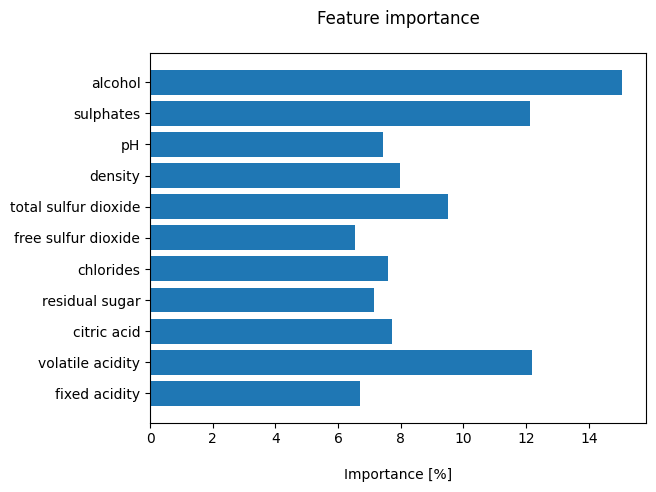

In [41]:
np.random.seed(0)
model_RFC_best.fit(X_norm, y)
# get importance
importance = model_RFC_best.feature_importances_

# summarize feature importance
fig, ax = plt.subplots()
ax.barh(X_norm.columns, importance*100)
ax.set_title('Feature importance\n')
ax.set_xlabel('\nImportance [%]')
plt.show()

Evidently, the three most important % alcohol, sulphates and volatile acidity.

# Conclusion

* Both models exhibit very high levels of utility as a decision support system for an oenologist.
* Mean absolute error achieved is in line with the initial Bayesian error estimate.
* High precision of predicted values within a tolerance of +/- 1.0 were achieved.
* The precision of the models can be greatly improved for the scale of 0 - 10 if a balanced dataset is provided.